In [1]:
GPUAcc = False
try:
    import cupy as xp
    GPUAcc = True
    print("Using GPU Acceleration")
except:
    import numpy as xp
import matplotlib.pyplot as plt
from MetropolisV2 import Metropolis, Metropolis2D
import pickle

Using GPU Acceleration
Using GPU Acceleration


In [2]:
Nspins = 8

# Jnonlocal = xp.random.normal(
#                     loc=0.0, scale=1.0, size=(Nspins, Nspins)) #xp.ones((Nspins, Nspins))
# Jnonlocal = (Jnonlocal + Jnonlocal.T)/2

Zenergy=0.0

In [105]:
xpos = xp.load("BrendanExamples/xpos.npy")/35.2e-6
ypos = xp.load("BrendanExamples/ypos.npy")/35.2e-6

Jnonlocal = xp.load("BrendanExamples/Jsample.npy")
K = xp.load("BrendanExamples/Ksample.npy")

In [83]:
w0 = 1

# effective interaction for Gaussian clumps
def MehlerFiniteSize(xi,xj,yi,yj,sigma,tval,kind=None):
    g = (1-2*sigma**2/w0**2) / (1+2*sigma**2/w0**2) # gamma factor
    
    G = lambda t: (1+g)**2/(4*(1-g**2*t**2)) * xp.exp(-(1+g)/(4*(1-g**2*t**2)) * 2/w0**2 * ((1+g*t**2)*(xi**2+yi**2+xj**2+yj**2) - 2*(1+g)*t*(xi*xj + yi*yj)))
    if kind == 'local':
        return 0.25 * (G(tval) + G(-tval))
    if kind == 'nonlocal':
        return 0.25 * 2*xp.real(G(1j*tval))
    return 0.25 * (G(tval) + G(-tval) + 2*xp.real(G(1j*tval)))

def make_J(xs, ys, sigmas, kind='nonlocal'):
    assert xs.shape == ys.shape, "The x- and y-coordinates have mismatched shapes!"
    
    if xs.ndim == 2: # we try to calculate multiple J matrices for each shot at once
        if type(sigmas) in [list,xp.ndarray]: # each shot has its own sigma
            return [make_J(x,y,s,kind) for x,y,s in zip(xs,ys,sigmas)]
        return [make_J(x,y,sigmas,kind) for x,y in zip(xs,ys)]
    
    r = xp.array([xs,ys]).T
    J = xp.array([[MehlerFiniteSize(x1,x2,y1,y2,sigmas,1,kind) for (x1,y1) in r] for (x2,y2) in r])
    return 4*J # the factor of 4 ensures that point particles have J between -1 and +1

def make_K(xs, ys, sigmaA, kind='nonlocal'):
    assert xs.shape == ys.shape, "The x- and y-coordinates have mismatched shapes!"
    
    if xs.ndim == 2: # we try to calculate multiple J matrices for each shot at once
        return [make_K(x,y,sigmaA,kind) for x,y in zip(xs,ys)]
    
    rdot = (xp.outer(xs,xs) + xp.outer(ys,ys)) / w0**2
    return 8 * sigmaA**2 / w0**2 * rdot * xp.sin(2*rdot)

In [56]:
MehlerFiniteSize(xpos[1], xpos[1], ypos[1], ypos[1], 4./35.2, 1.0, kind='nonlocal')

array(0.02511536)

In [57]:
Jnonlocal[1,1]

array(0.10046143)

In [60]:
make_K(xpos[0], ypos[0], 4./35.2)

array([[-0.22006338]])

In [61]:
K[0,0]

array(-0.22006338)

In [92]:
def harm_greens_fnc_v2(posx, posy, sigma, tval):
    N = posx.shape[0]
    g = (1-2*sigma**2) / (1+2*sigma**2) # gamma factor

    normalization = (1+g)**2/(4*(1-g**2*tval**2)) # Differs by the paper normalization by a missing 1/4
                                                  # This comes from Brandan's code base and make point particles have t=1.
    x = xp.einsum("i,j->ij",posx,xp.ones(N)) 
    xT = xp.einsum("i,j->ij",xp.ones(N),posx)

    y = xp.einsum("i,j->ij",posy,xp.ones(N)) 
    yT = xp.einsum("i,j->ij",xp.ones(N),posy)

    sumOfSquares = 0.5*(xp.square(x - xT) + xp.square(y - yT) + xp.square(x + xT) + xp.square(y + yT))
    dotProduct = 0.25*(xp.square(x + xT) + xp.square(y + yT) - xp.square(x - xT) - xp.square(y - yT))

    term1 = (1+g*tval**2)*sumOfSquares
    term2 = -2*(1+g)*tval*dotProduct

    return normalization*xp.exp(-(1+g)/(4*(1-g**2*tval**2))*2*(term1 + term2))

def K_fnc(posx, posy, sigma):
    rdot = (xp.outer(posx,posx) + xp.outer(posy,posy))
    return 8 * sigma**2 * rdot * xp.sin(2*rdot)

def harm_greens_fnc_diagonal_v2(posx, posy, sigma, tval):
    N = posx.shape[0]
    g = (1-2*sigma**2) / (1+2*sigma**2) # gamma factor

    normalization = (1+g)**2/(4*(1-g**2*tval**2)) # Differs by the paper normalization by a missing 1/4 from Brandan

    term1 = (1+g*tval**2)*2*(xp.square(posx) + xp.square(posy))
    term2 = -2*(1+g)*tval*(xp.square(posx) + xp.square(posy))

    return normalization*xp.exp(-(1+g)/(4*(1-g**2*tval**2))*2*(term1 + term2))

def confoncal_greens_fnc_nonlocal_v2(posx, posy, sigma, tval):
    return 2*xp.real(harm_greens_fnc_v2(posx, posy, sigma, 1j*tval))

def confoncal_greens_fnc_local_v2(posx, posy, sigma, tval):
    return harm_greens_fnc_diagonal_v2(posx, posy, sigma, tval) + harm_greens_fnc_diagonal_v2(posx, posy, sigma, -tval)

def generate_Js_v2(pos_sigma = 0.2, sigma_A=4.0/35.2):
    posx = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)
    posy = xp.random.normal(loc=0,scale=pos_sigma, size=Nspins)

    Jnonlocal = xp.real(confoncal_greens_fnc_nonlocal_v2(posx,posy, sigma_A,1.0))
    K = K_fnc(posx, posy, sigma_A)
    Jlocal = xp.real(confoncal_greens_fnc_local_v2(posx, posy, sigma_A,1.0))
    return Jnonlocal, K, Jlocal

In [106]:
harm_greens_fnc_diagonal_v2(xpos, ypos, 4.0/35.2,1.0)

array([2.42, 2.42, 2.42, 2.42, 2.42, 2.42, 2.42, 2.42])

In [109]:
xp.diag(make_J(xpos, ypos, 4.0/35.2, kind='local'),0)

array([9.68, 9.68, 9.68, 9.68, 9.68, 9.68, 9.68, 9.68])

In [110]:
xp.diag(make_J(xpos, ypos, 4.0/35.2, kind='local'),0)/harm_greens_fnc_diagonal_v2(xpos, ypos, 4.0/35.2,1.0)

array([4., 4., 4., 4., 4., 4., 4., 4.])

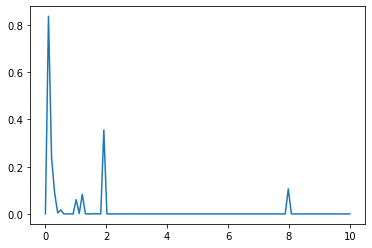

In [6]:
sigma_A = 4 # um

sigma = xp.linspace(0.0,10.0,100)
ratios = xp.zeros(100)
stds = xp.zeros(100)
for i in range(100):
    Jnonlocal, K, Jlocal = generate_Js_v2(pos_sigma=sigma[i])
    ratios[i] = xp.mean(xp.diag(xp.abs(Jnonlocal),0)/xp.abs(Jlocal))
    stds[i] = xp.std(Jlocal)
#plt.plot(sigma.get(), ratios.get())
plt.plot(sigma.get(), stds.get())

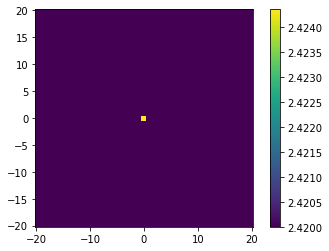

In [76]:
x = xp.linspace(-20.0,20.0,100)
y = xp.linspace(-20.0,20.0,100)
X,Y = xp.meshgrid(x,y)
Z = 0.*1j*X

xpr = 1.3
ypr = 0.2

for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        # K_fnc(xp.array([X[i,j].get(),xpr]), xp.array([Y[i,j].get(),ypr]), 4.0/35.2)
        temp = confoncal_greens_fnc_local_v2(xp.array([X[i,j].get(),xpr]), xp.array([Y[i,j].get(),ypr]), 4.0/35.2, 1.0)
        Z[i,j] = temp[0]
plt.pcolor(X.get(),Y.get(),xp.real(Z).get())
plt.gca().set_aspect('equal')
plt.colorbar()

In [14]:
Z[10,10]

array(2.42+0.j)

In [104]:
confoncal_greens_fnc_local_v2(xp.array([1e10]), xp.array([0.0]), 4.0/35.2, 1.0)

array([2.42])

In [ ]:
Jlocals = xp.load("ConfocalJlocals.npy")
Jnonlocals = xp.load("ConfocalJnonlocals.npy")

gs = [0.25,0.5,1.0,1.25,2.0]



for g in gs:
    for i in range(Jlocal.shape[0]):
        Tc = max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

        N = 2*max(Jlocal)+2*Tc

        Jnonlocal = Jnonlocal/N
        Jlocal = Jlocal/N

        Tfinal = 0.01*Tc
        AnnealHigh = Tfinal*1.5
        AnnealT = 500

        met = Metropolis2D(Jnonlocal, Tfinal, steps=int(3*AnnealT), sigma=xp.pi/10, Nspins=Nspins, AnnealT=AnnealT, Nrepl=1000, AnnealHigh=AnnealHigh)
        final_state = met.run()
        fig, ax = plt.subplots()
        ax.set_title(f"Annealing Time = {AnnealT} steps")
        met.plot_overlap_distribution(ax=ax)
        met.plot_energy_record()
        met.plot_overlap_distribution()
        plt.show()

In [304]:
Jlocals.shape[0]

10

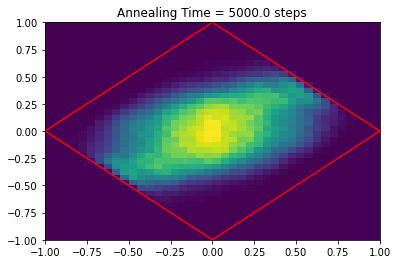

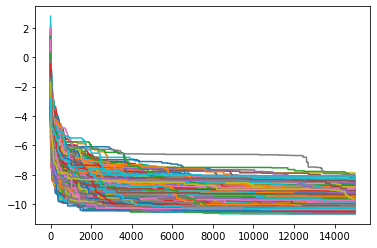

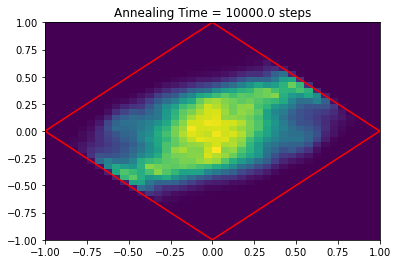

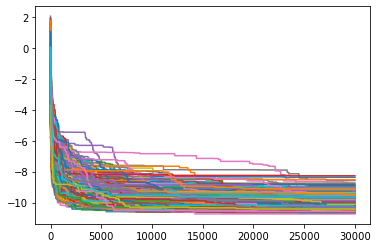

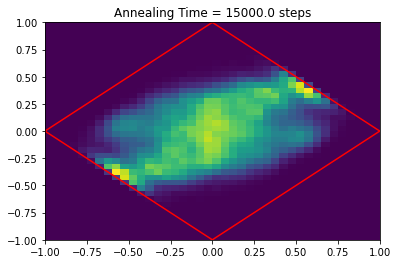

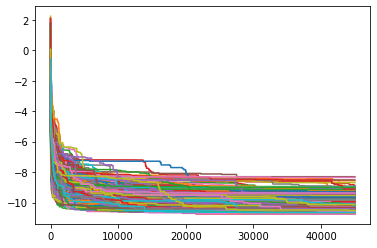

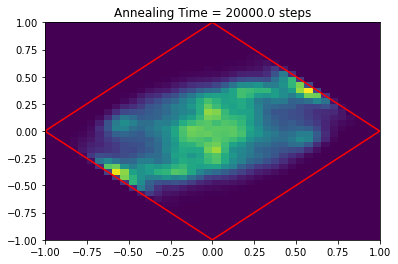

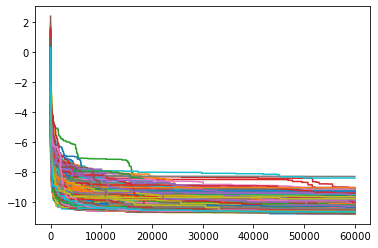

In [194]:
Nspins = 8

Zenergy = 1.0

Jlocals = xp.load("ConfocalJlocals_v2.npy")
Ks = xp.load("ConfocalKs_v2.npy")
Jnonlocals = xp.load("ConfocalJnonlocals_v2.npy")

i = 8
g = 2.25

Tc = max(xp.abs(xp.linalg.eigvalsh(Jnonlocals[i])))

Tfinal = 0.0001*Tc
AnnealHigh = Tfinal*2.0

for AnnealT in [5000., 10000., 15000., 20000.]:
    met = Metropolis(g*Jnonlocals[i], g*Jlocals[i], g*Ks[i], Zenergy, Tfinal,
                                steps=int(3*AnnealT), sigma=xp.pi/10, sigmaR=0.05, Nrepl=1000, Nspins=Nspins, AnnealT=AnnealT, AnnealHigh=AnnealHigh)
    final_state = met.run()
    fig, ax = plt.subplots()
    ax.set_title(f"Annealing Time = {AnnealT} steps")
    met.plot_angle_overlap_distribution(ax=ax)
    met.plot_energy_record()
    plt.show()

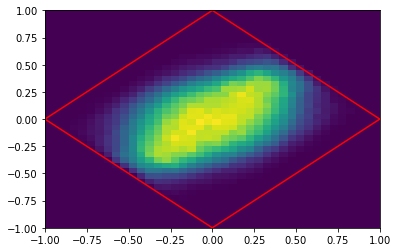

In [191]:
met.plot_angle_overlap_distribution()

In [193]:
Nspins = 8

Zenergy = 1.0

Jlocals = xp.load("ConfocalJlocals_v2.npy")
Ks = xp.load("ConfocalKs_v2.npy")
Jnonlocals = xp.load("ConfocalJnonlocals_v2.npy")

i = 8
g = 2.25

Tc = max(xp.abs(xp.linalg.eigvalsh(Jnonlocals[i])))

Tfinal = 0.0001*Tc
AnnealHigh = Tfinal*2.0

for AnnealT in [50000, 100000]:
    met = Metropolis(g*Jnonlocals[i], g*Jlocals[i], g*Ks[i], Zenergy, Tfinal,
                                steps=int(3*AnnealT), sigma=xp.pi/10., Nrepl=1000, Nspins=Nspins, AnnealT=AnnealT, AnnealHigh=AnnealHigh)
    final_state = met.run()
    fig, ax = plt.subplots()
    ax.set_title(f"Annealing Time = {AnnealT} steps")
    met.plot_angle_overlap_distribution(ax=ax)
    met.plot_energy_record()
    plt.show()

KeyboardInterrupt: 

In [ ]:
Zenergies = [12.,14.,16.,18.,20.,22.,24.,26.,28.]
fig, axs = plt.subplots(3,len(Zenergies)//3)
fig.set_figwidth(4*len(Zenergies))
fig.set_figheight(7*3)

epsilon_c = 2*10.0 + 2*max(xp.abs(xp.linalg.eigvalsh(Jnonlocal)))

for i in range(len(Zenergies)):
        with open(f"MetropolisRuns/3component/Ze={Zenergies[i]:.2e},T=5.0e-02.pickle", "rb") as f:
                loadedmet = pickle.load(f)
        print(i//(len(Zenergies)//3), i % (len(Zenergies)//3))
        ax = axs[i//(len(Zenergies)//3), i % (len(Zenergies)//3)]
        loadedmet.plot_overlap_distribution(ax=ax)
        ax.set_title("$\epsilon$" + f" = {Zenergies[i]/epsilon_c:.2f}"+" $\epsilon_{SR}$")
        ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
        ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
        ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

0.001676745289933492
0.0027666734473787017
0.00250191169271477
0.0025166665891065893
0.0028805014839106877
0.0028293866121848364
0.002975607444268172
0.0025178588985376254
0.0017689447494077712
0.0023867254015080804


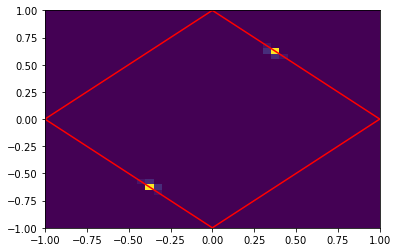

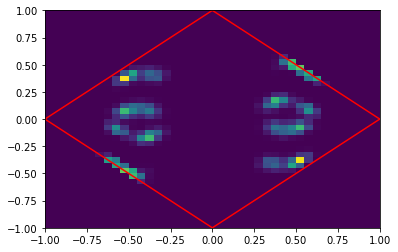

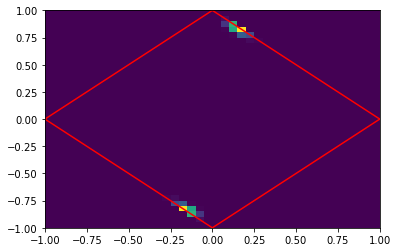

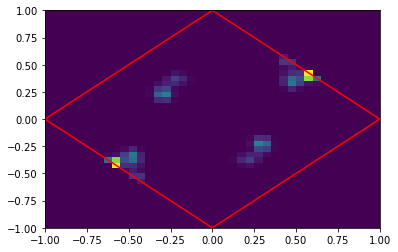

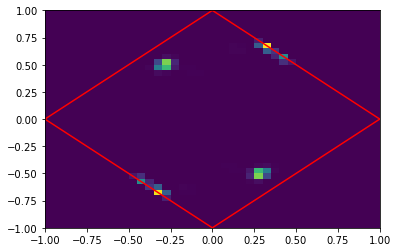

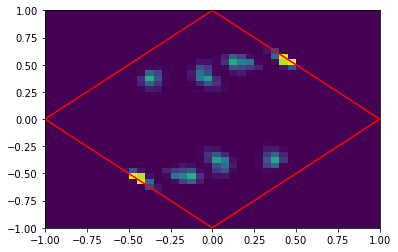

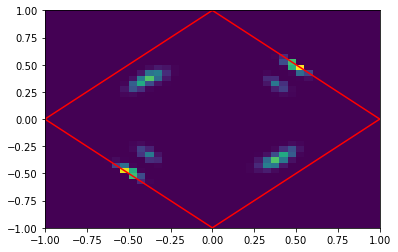

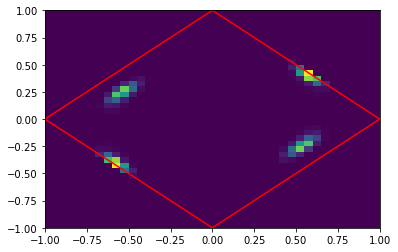

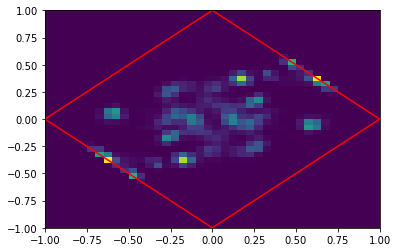

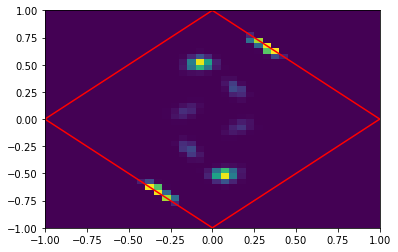

In [186]:
for num in [0,3,4,6,7,10,11,13,16,18]:
    with open(f"MetropolisRuns/FindingJs/{num}.pickle", "rb") as f:
        loadedmet = pickle.load(f)
    print(loadedmet.Tfinal)
    loadedmet.plot_overlap_distribution()
    plt.show()
    

0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2
0 0
0 1
0 2
1 0
1 1
1 2


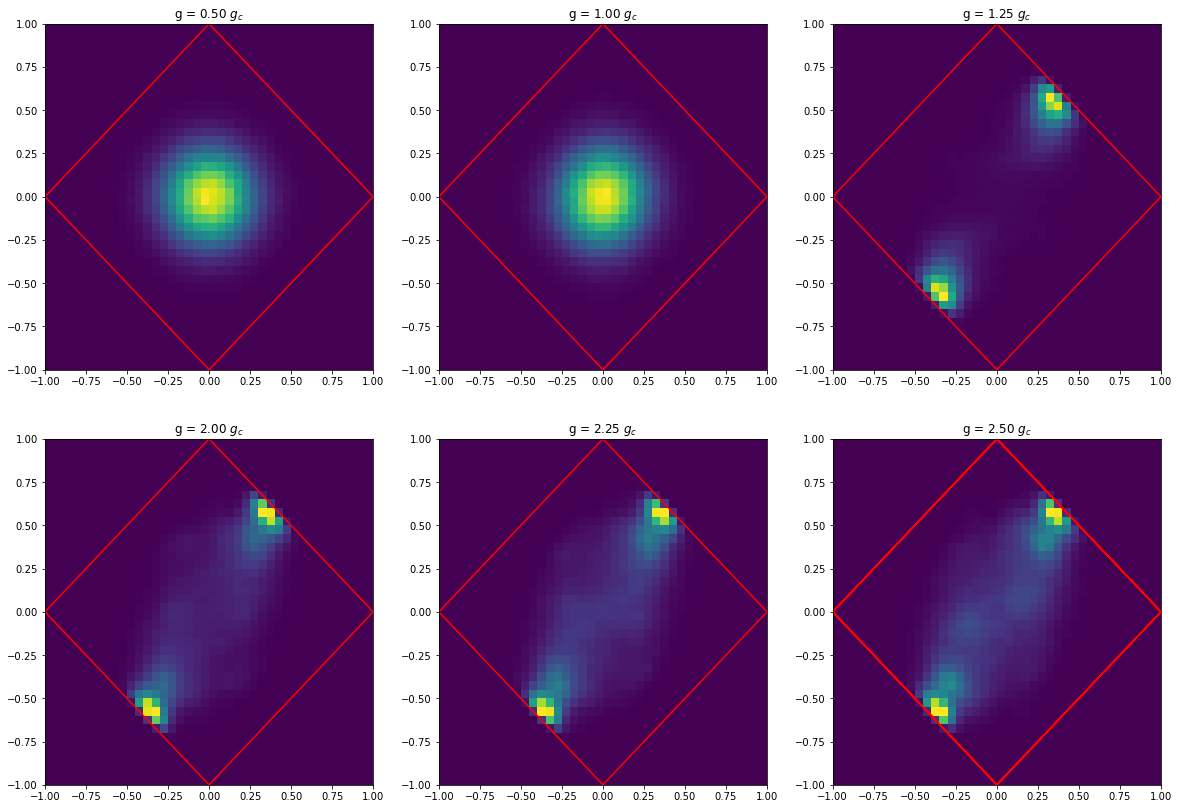

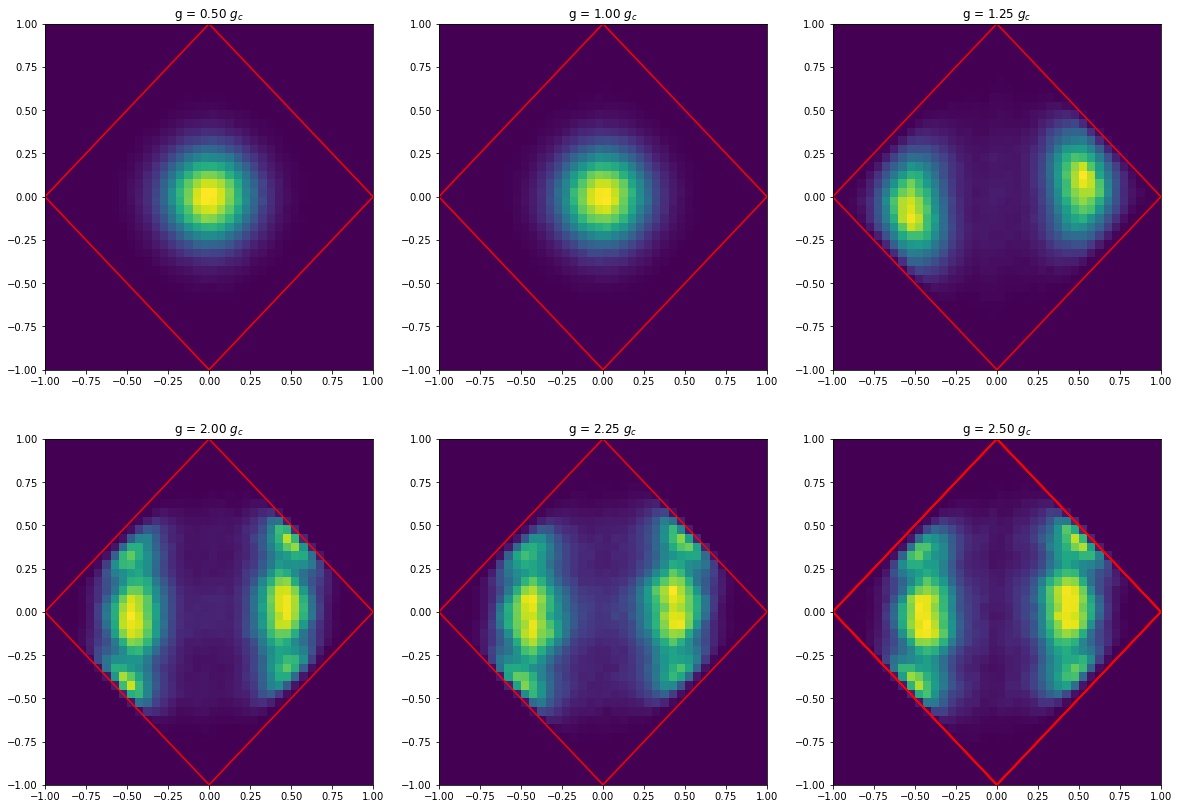

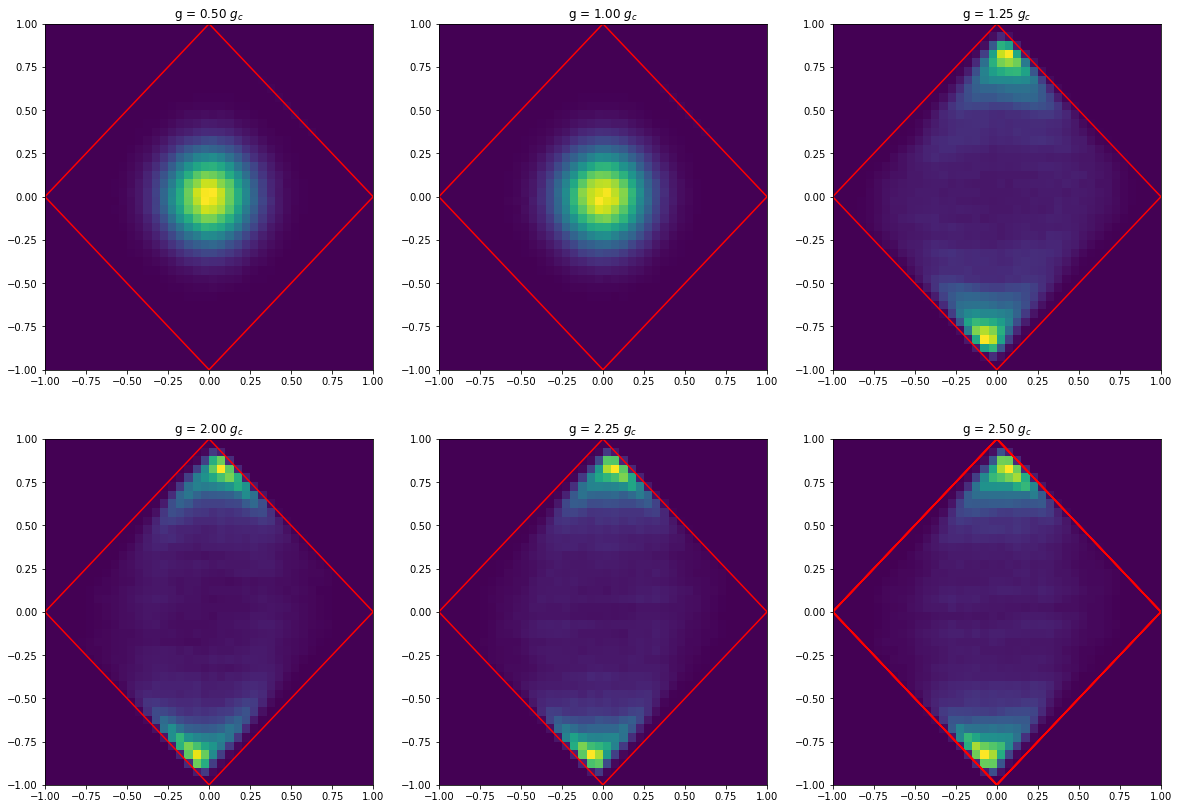

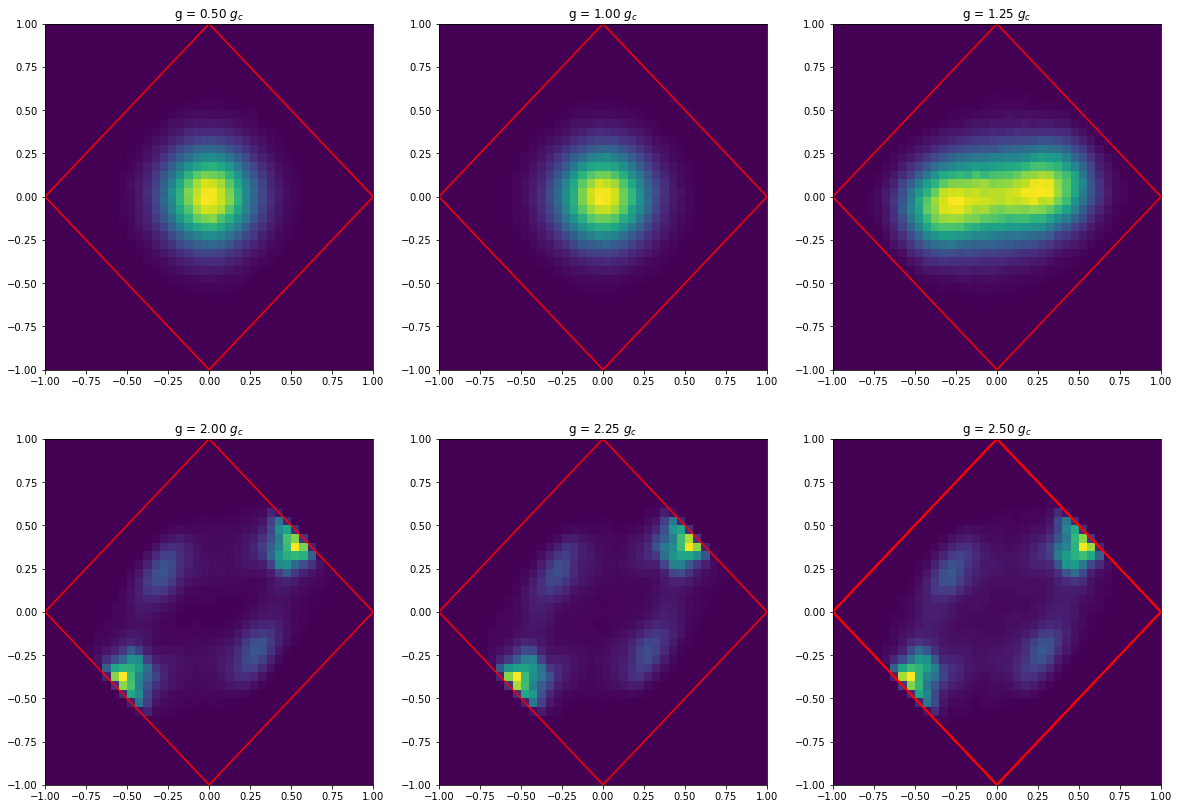

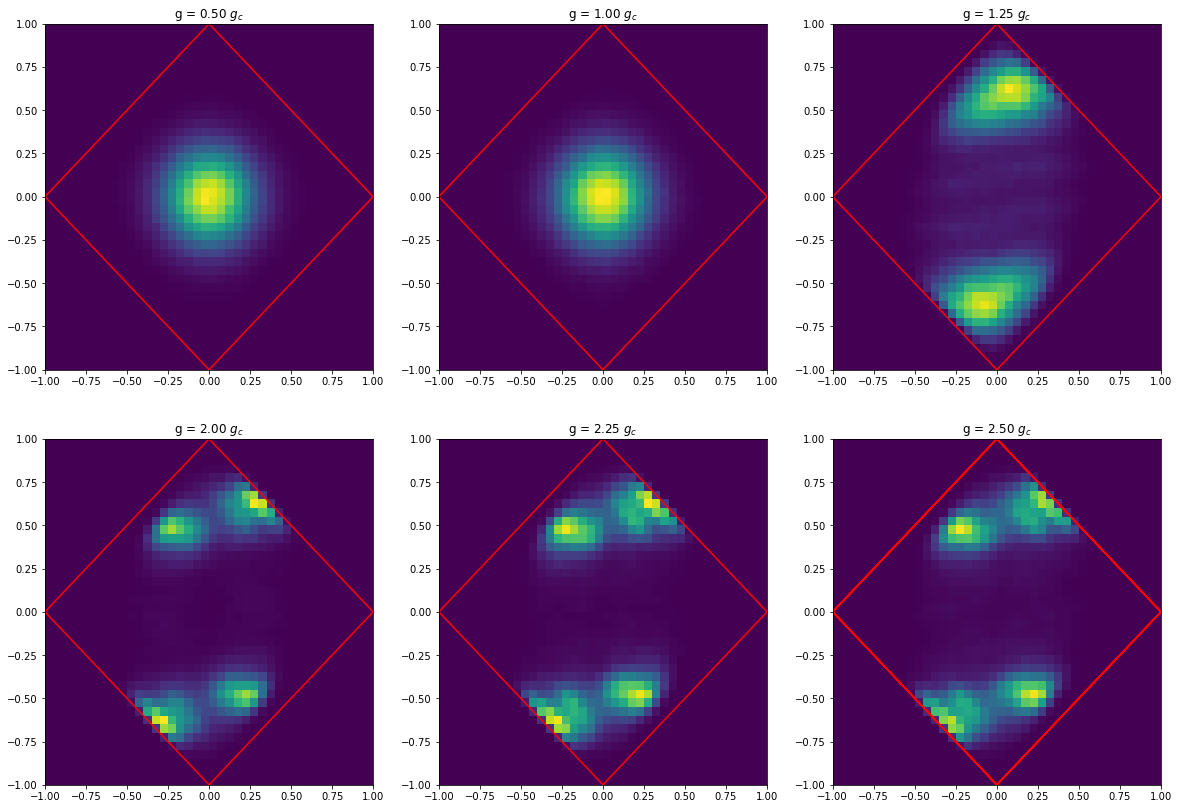

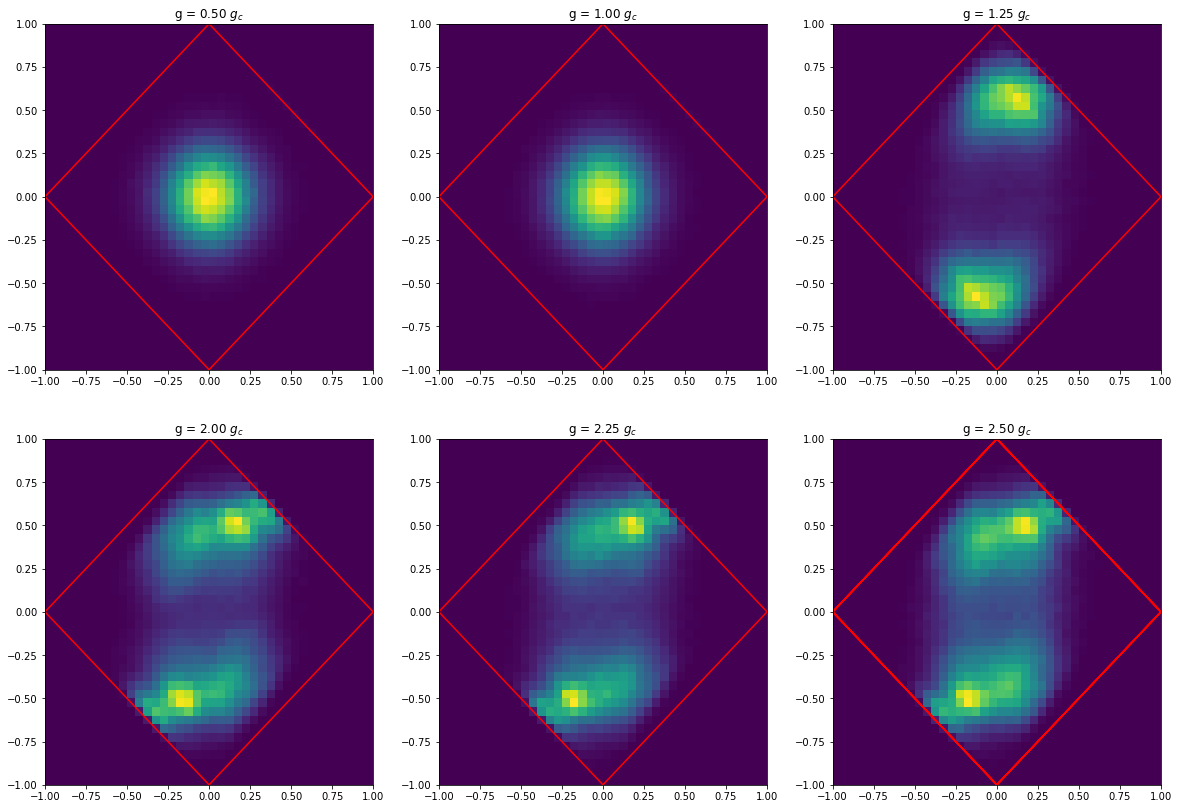

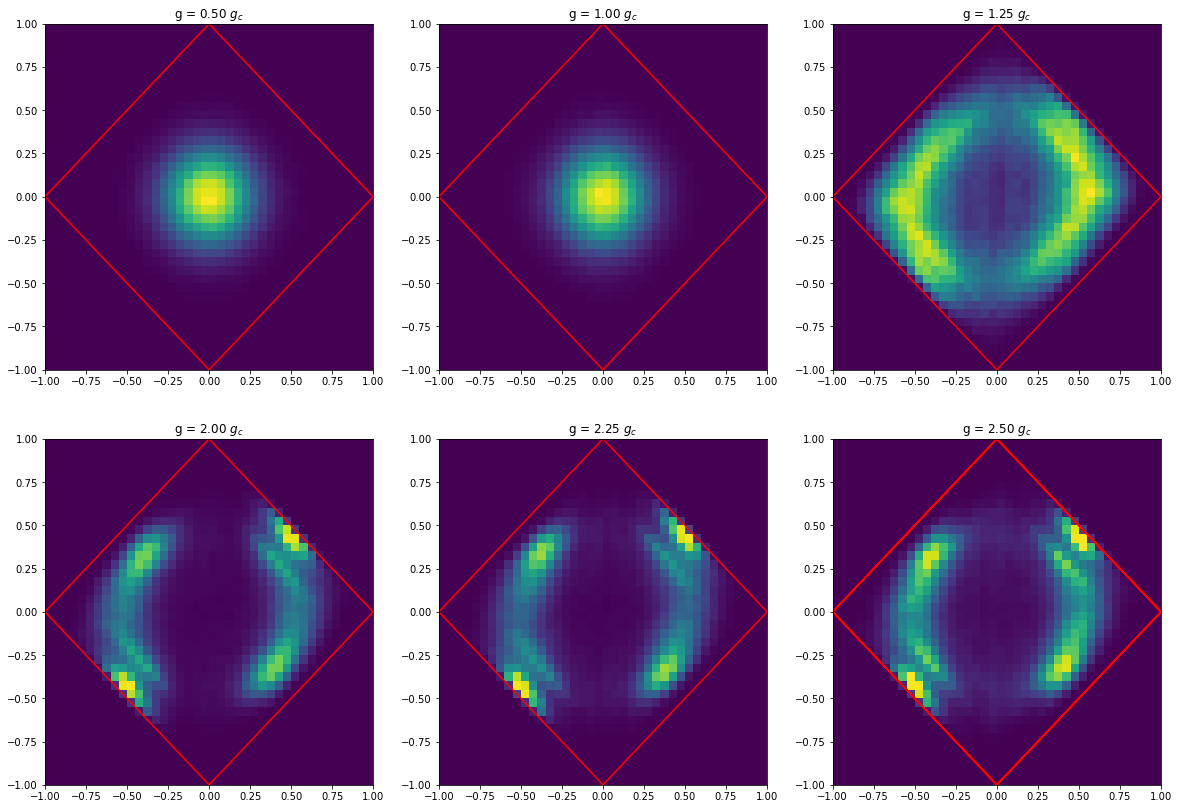

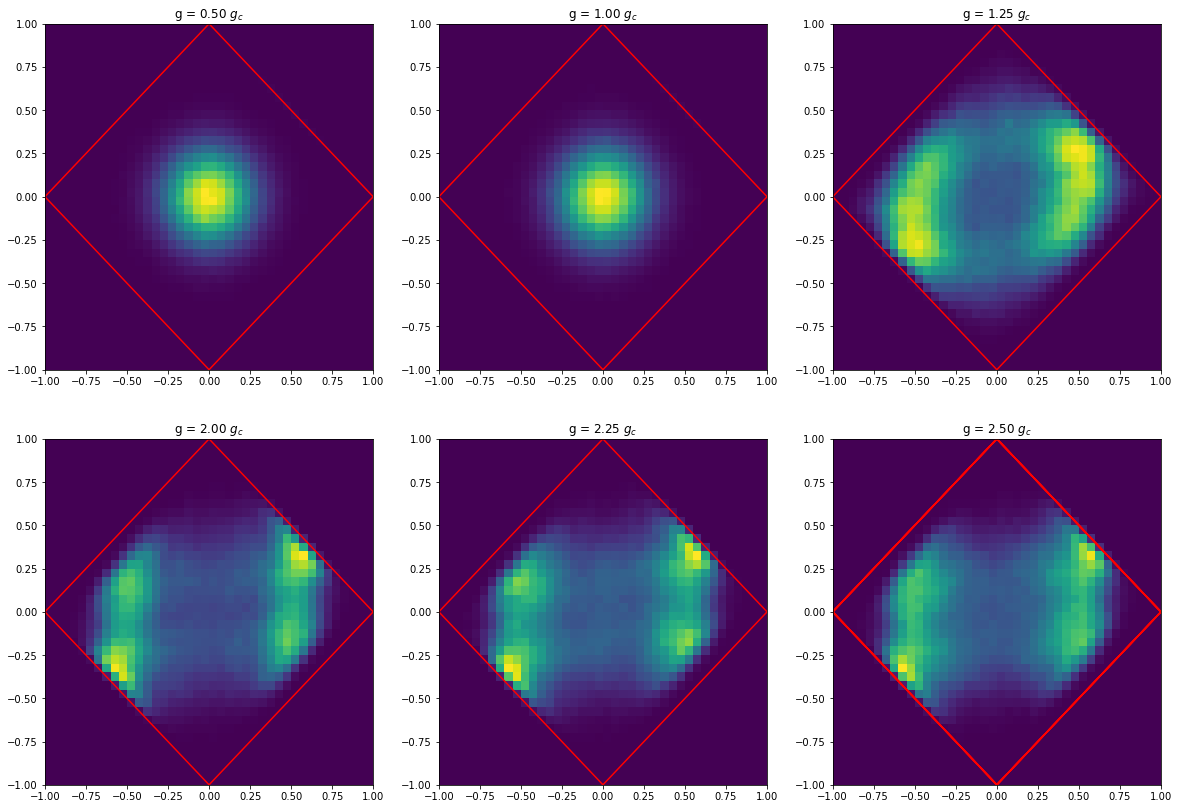

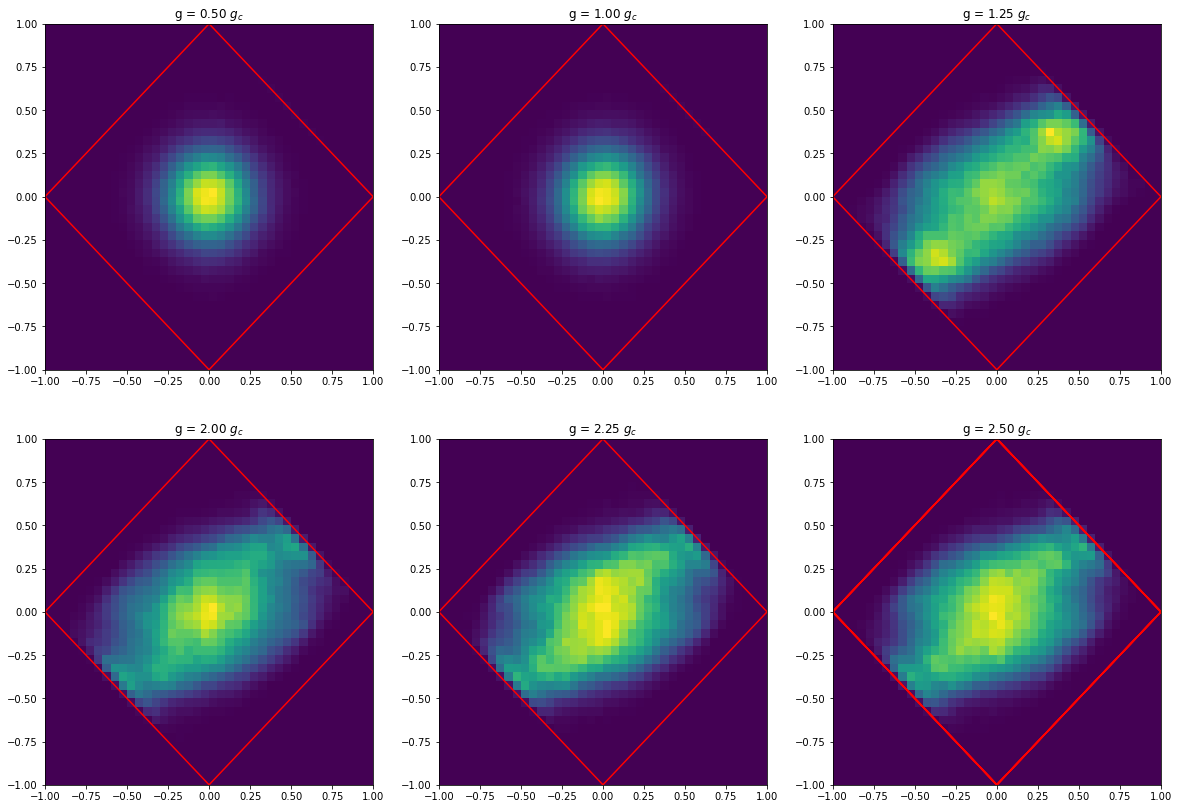

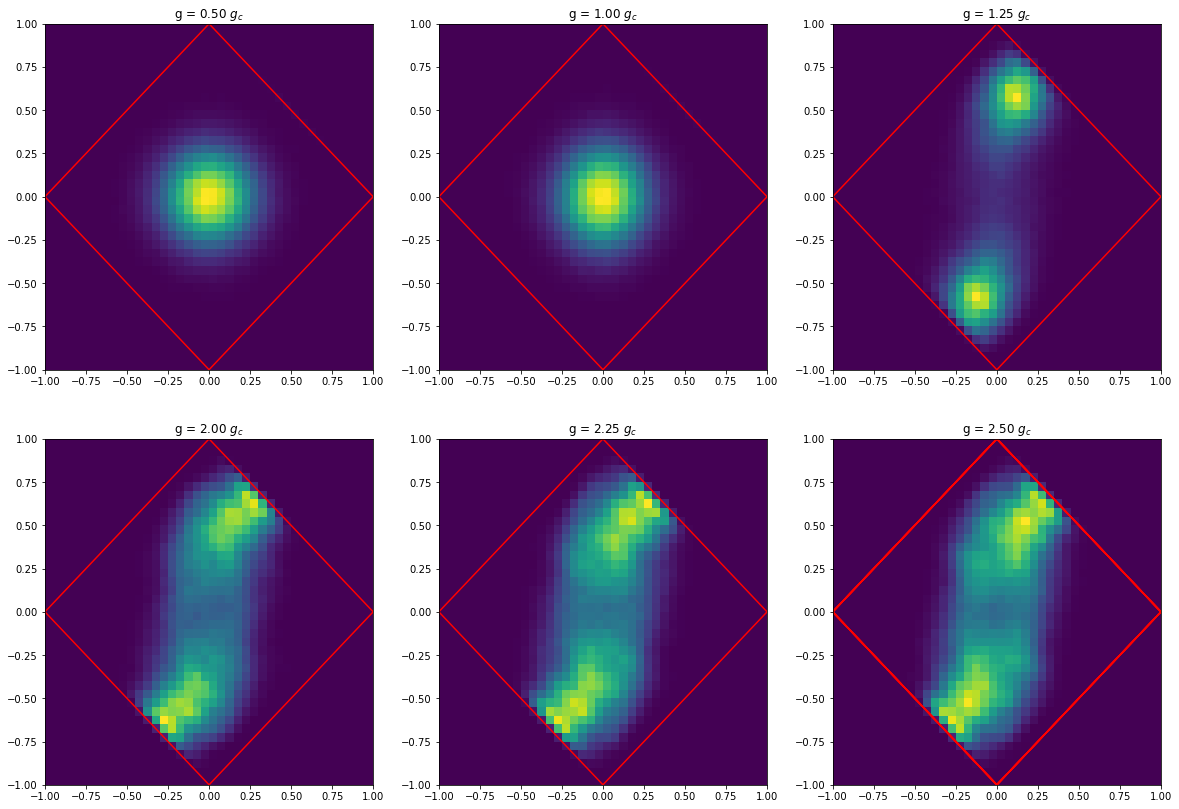

In [184]:
gs = [0.5,1.0,1.25,2.0,2.25,2.5]#[2.25, 2.5, 3.0, 5.0]#

for j in range(10):
        fig, axs = plt.subplots(2,3)
        fig.set_figwidth(4*5)
        fig.set_figheight(7*2)

        for i in range(len(gs)):
                with open(f"MetropolisRuns/3component/J{j}g={gs[i]:.2f}T=0.0001Tc.pickle", "rb") as f:
                        loadedmet = pickle.load(f)
                print(i//3, i % 3)
                ax = axs[i//3, i % 3]
                loadedmet.plot_angle_overlap_distribution(ax=ax)
                ax.set_title(f"g = {gs[i]:.2f}"+" $g_c$")
                ax.plot([0.0, 1.0], [1.0, 0.0], 'r-')
                ax.plot([0.0, 1.0], [-1.0, 0.0], 'r-')
                ax.plot([0.0, -1.0], [-1.0, 0.0], 'r-')
                ax.plot([0.0, -1.0], [1.0, 0.0], 'r-')

        fig.savefig(f"MetropolisRuns/Figures/J{j}SuperradiantRamp.pdf")

In [173]:
xp.linalg.norm(loadedmet.Jnonlocal)

array(0.44408168)

In [174]:
xp.linalg.norm(loadedmet.K)

array(0.15549897)